# 野菜を価格変動のスペクトラム画像から分類する by Oregin
野菜を価格変動のスペクトラム画像に変換し、K-meansで分類するのサンプルコードです。
※Google Colab（CPU利用,GPU不要）で実行可能です。

- base_path : このファイルを入れておくディレクトリ（各種パスの設定にて、保存した絶対パスを指定してください）
- base_path/data : train_data.csv,weather.csv,submission.csvを入れておくディレクトリ

In [ ]:
#野菜を何分割するかを指定
n_cluster = 15

# ライブラリのインポート

In [ ]:
import numpy as np
import random

import pandas as pd

import os

import warnings
warnings.simplefilter('ignore')
from skimage.transform import resize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# 各種パスの設定

In [ ]:
# 各種パスの設定
######################################################################
base_path = '/#######/########' # ベースとなるパスを指定してください。#######
######################################################################
os.makedirs(os.path.join(base_path,'result'), exist_ok=True)  # 提出用ファイルを出力するディレクトリを作成
train_data_path = os.path.join(base_path,'data/train_data.csv') # 訓練データのパスを指定
weather_data_path = os.path.join(base_path,'data/weather.csv') # 気象データのパスを指定
submit_data_path = os.path.join(base_path,'data/submission.csv') # 提出用サンプルfileのパスを指定

# 訓練データの読み込み

In [ ]:
# 訓練データの読み込み
train_data = pd.read_csv(train_data_path).fillna(method='ffill')
train_data.shape

(47, 341)

In [ ]:
# 列名から野菜の種類と地域を抽出
columns = train_data.columns[1:]  # タイムスタンプの列を除外
vegetable_types = [col.split('_')[0] for col in columns]
regions = [col.split('_')[1] for col in columns]
print(len(vegetable_types))
print(len(regions))

340
340


# 関数の定義

## 野菜の価格データの推移からスペクトラム化した画像を取得する関数

In [ ]:
def Function_make_vegetables_spectrum_images(df):
  # 画像化のための準備
  images = []
  vegetables = []
  # 野菜ごとに処理を行う
  for col in df.columns:
      vegetable_data = df[col].values

      # スペクトラム変換を適用して画像化
      spectrum = np.fft.fft(vegetable_data)
      spectrum = np.abs(spectrum)
      spectrum = np.log1p(spectrum)  # ログスケールで強調

      # 画像サイズを統一
      spectrum_resized = resize(spectrum, (128, 128))

      images.append(spectrum_resized)
      vegetables.append(col)
  return images,vegetables

## 野菜価格のスペクトラム化した画像をクラスタリングする関数

In [ ]:
def Function_clustering_images(images, vegetables, n_clusters=15):
  # 画像データを行列に変換
  X = np.stack(images)
  X = X.reshape(X.shape[0], -1)  # 2次元に変換

  # K-meansクラスタリングを実行
  kmeans = KMeans(n_clusters=n_clusters, random_state=42,n_init=10)
  clusters = kmeans.fit_predict(X)
  # 結果を表示
  results = pd.DataFrame({'Vegetable': vegetables, 'Cluster': clusters})
  return results

## 野菜毎にクラスタを多数決で決める関数

In [ ]:
def Function_mode_cluster_by_vegetable(df):
  # 野菜名と地域名に分割する
  df[['Vegetable_Name', 'Region']] = df['Vegetable'].str.split('_', expand=True)

  # 野菜名ごとのClusterを多数決で求める
  df_agg = df.groupby('Vegetable_Name')['Cluster'].agg(lambda x: x.value_counts().index[0]).reset_index()

  # 野菜名ごとのClusterを出力する
  return df_agg

## クラスタごとの野菜リストを取得する関数

In [ ]:
def Function_mode_vegetable_num_list(df_agg,cluster_num):
  vegetable_num_list = list(df_agg[df_agg['Cluster']==cluster_num].index)
  return vegetable_num_list

#  野菜毎の価格の変動周期をスペクトラム化し分類

## 野菜毎にスペクトラム化した画像を取得

In [ ]:
#野菜毎にスペクトラム化した画像を取得
images,vegetables = Function_make_vegetables_spectrum_images(train_data.drop('id',axis=1))

In [ ]:
len(images)

340

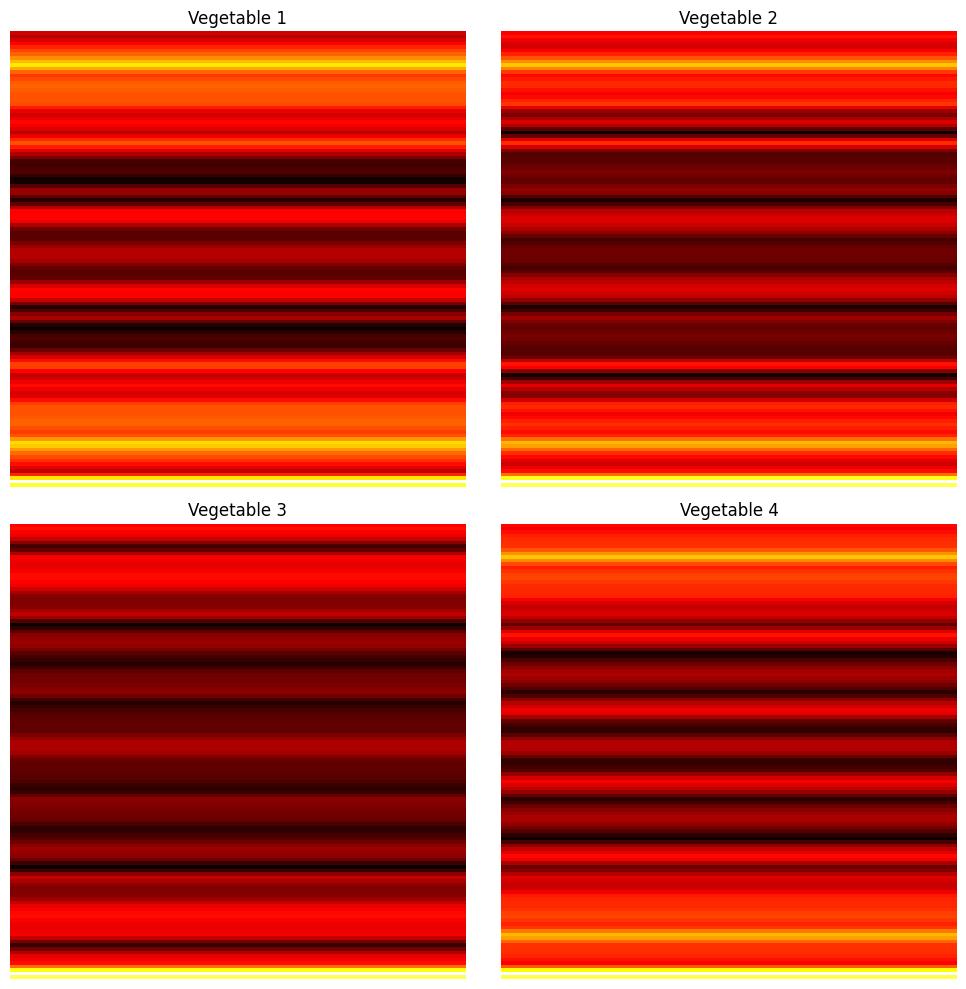

In [ ]:
# スペクトラム画像を表示
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i in range(4):
    ax = axs[i]
    ax.imshow(images[i], cmap='hot', origin='lower')
    ax.set_title(f'Vegetable {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


## スペクトラム化した画像で野菜をクラスタリング

In [ ]:
#スペクトラム化した画像で野菜をクラスタリング
results = Function_clustering_images(images, vegetables, n_clusters=n_cluster)

## クラスタリングした結果をもとに野菜毎にクラスを多数決

In [ ]:
#クラスタリングした結果を野菜毎に多数決
df_agg = Function_mode_cluster_by_vegetable(results)

In [ ]:
for i in range(n_cluster):
  print(df_agg[df_agg['Cluster']==i])

  Vegetable_Name  Cluster
7           さといも        0
   Vegetable_Name  Cluster
5            こまつな        1
27         ほうれんそう        1
28            みずな        1
   Vegetable_Name  Cluster
16           たまねぎ        2
17           だいこん        2
   Vegetable_Name  Cluster
8          さやいんげん        3
12          しゅんぎく        3
21             にら        3
23           にんにく        3
29            みつば        3
31           れんこん        3
   Vegetable_Name  Cluster
2            かぼちゃ        4
15         その他の野菜        4
24             ねぎ        4
35            トマト        4
41          生しいたけ        4
   Vegetable_Name  Cluster
0           えのきだけ        5
6             ごぼう        5
11            しめじ        5
13           しょうが        5
20            なめこ        5
   Vegetable_Name  Cluster
14         その他の菜類        6
18         ちんげんさい        6
40            レタス        6
   Vegetable_Name  Cluster
3            かんしょ        7
26          ばれいしょ        7
   Vegetable_Name  Cluster
9          さやえんどう        8
36 

# 以上